# Inverse Kinematics for a 3R Manipulator
In this notebook, we'll compute the inverse kinematics of a 3-link (3R) robot arm using the Robotics Toolbox for Python.


In [1]:
import roboticstoolbox as rtb
from math import pi
from spatialmath import SE3
import numpy as np

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Defining the Robot
We'll begin by defining the 3R robot. Each revolute joint (R) will have a standard Denavit-Hartenberg (DH) parameter.


In [2]:


robot = rtb.DHRobot(
    [
        rtb.RevoluteMDH(alpha = 0.0     ,a = 0.0      ,d = 0.2      ,offset = 0.0),
        rtb.RevoluteMDH(alpha = pi/2   ,a = 0.0      ,d = 0.02       ,offset = 0.0),
        rtb.RevoluteMDH(alpha = 0     ,a = 0.25       ,d = 0.0      ,offset = 0.0),

    ],tool = SE3.Tx(0.28),
    name = "RRR_Robot"
)

print(robot)

DHRobot: RRR_Robot, 3 joints (RRR), dynamics, modified DH parameters
┌──────┬───────┬─────┬──────┐
│ aⱼ₋₁ │ ⍺ⱼ₋₁  │ θⱼ  │  dⱼ  │
├──────┼───────┼─────┼──────┤
│  0.0 │  0.0° │  q1 │  0.2 │
│  0.0 │ 90.0° │  q2 │ 0.02 │
│ 0.25 │  0.0° │  q3 │  0.0 │
└──────┴───────┴─────┴──────┘

┌──────┬──────────────────────────────────────┐
│ tool │ t = 0.28, 0, 0; rpy/xyz = 0°, 0°, 0° │
└──────┴──────────────────────────────────────┘



## Inverse Kinematics
To compute the inverse kinematics, we'll specify a desired end effector position and use the robot's IK methods to compute the joint angles.


In [3]:
from scipy.optimize import minimize

def custom_ikine(robot, T_desired, initial_guess):
    """
    Custom function to compute inverse kinematics using optimization.
    
    Parameters:
    - robot: The robot object
    - T_desired: Desired end-effector pose
    - initial_guess: Initial guess for joint angles
    
    Returns:
    - q: Computed joint angles
    """
    # Define the objective function
    def objective(q):
        T_actual = robot.fkine(q)
        return np.linalg.norm(T_actual.A - T_desired.A)
    
    # Run the optimization
    result = minimize(objective, initial_guess, bounds=[(-pi, pi) for _ in initial_guess])
    
    return result.x




In [4]:
# Desired end effector pose
T_desired = SE3(1.207, 1.207, 1.707)

# Use the custom IK function
initial_guess = [[0, 0, 0], [pi/2, pi/2,pi/2]]
for init_guess in initial_guess:
    
    q_sol = custom_ikine(robot, T_desired, init_guess)
    print("q solution")
    print(q_sol)

    # Compute forward kinematics
    print("end-effector pose")
    T = robot.fkine(q_sol)
    print(T)

q solution
[ 0.3365106   0.87259595 -0.8439138 ]
end-effector pose
   0.9435   -0.02707   0.3302    0.4225    
   0.3301   -0.009469 -0.9439    0.1266    
   0.02868   0.9996    0         0.3995    
   0         0         0         1         

q solution
[3.14159265 2.15050452 0.71843378]
end-effector pose
   0.9631    0.2693    0         0.4066    
   0         0         1         0.02      
   0.2693   -0.9631    0         0.4846    
   0         0         0         1         



In [5]:
# Desired end effector pose
T_desired = SE3(0.4225, 0.1266, 0.3995)

# Compute inverse kinematics
q_sol_ik_LM, *_ = robot.ikine_LM(T_desired)  # Note: Some robots might have multiple IK solutions

print(q_sol_ik_LM)

[3.03363713 1.54161466 1.73893242]


## Visualization
Now, let's visualize the robot's configuration for the computed joint angles.


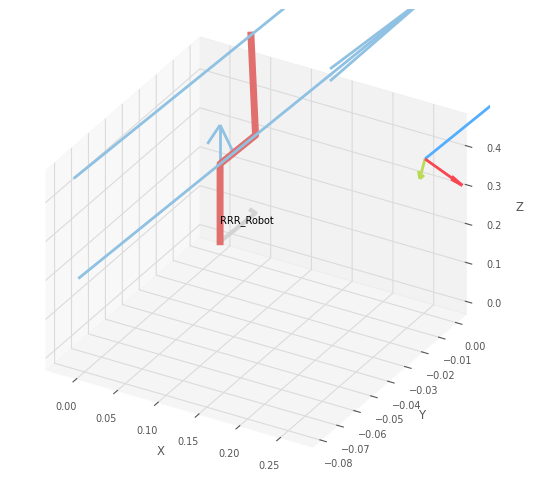

end-effector pose
   0.9846   -0.1377    0.1077    0.2706    
  -0.1067    0.01492   0.9942   -0.009209  
  -0.1385   -0.9904    0         0.4111    
   0         0         0         1         



<Figure size 640x480 with 0 Axes>

In [6]:
# Plot the robot
fig = robot.plot(q_sol_ik_LM, block=False)

# Compute forward kinematics
print("end-effector pose")
T = robot.fkine(q_sol_ik_LM)
print(T)

Converged in 820 iterations
Final joint angles (in radians): [  0.64341725  11.44824785 -23.5522634 ]
Final end-effector position: [0.29997205 0.19994131 0.10007576]
Desired end-effector position: [0.3 0.2 0.1]


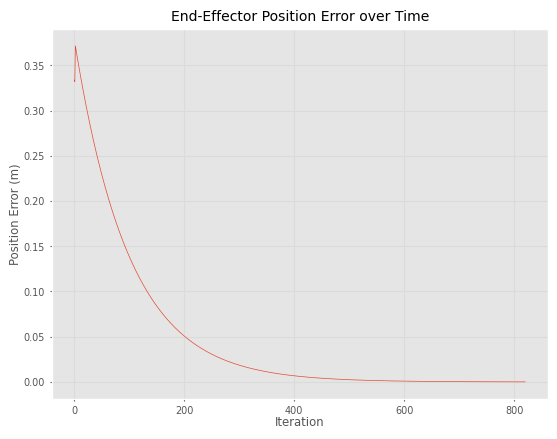

In [10]:
import roboticstoolbox as rtb
from math import pi
from spatialmath import SE3
import numpy as np
import matplotlib.pyplot as plt

# Define the robot
robot = rtb.DHRobot(
    [
        rtb.RevoluteMDH(alpha=0.0,    a=0.0,  d=0.2,  offset=0.0),
        rtb.RevoluteMDH(alpha=pi/2,   a=0.0,  d=0.02, offset=0.0),
        rtb.RevoluteMDH(alpha=0.0,    a=0.25, d=0.0,  offset=0.0),
    ],
    tool=SE3.Tx(0.28),
    name="RRR_Robot"
)

# Initial joint angles (in radians)
q = np.array([0.0, 0.0, 0.0])

# Desired end-effector position (p_setpoint)
# Let's set the desired position to (0.3, 0.2, 0.1)
p_setpoint = np.array([0.3, 0.2, 0.1])

# Control parameters
kp = 1.0   # Proportional gain
dt = 0.01  # Time step
iterations = 1000  # Number of iterations

# Lists to store data for plotting
errors = []
positions = []

for i in range(iterations):
    # Forward kinematics to get current end-effector position
    T = robot.fkine(q)
    p_now = T.t  # Extract translational component
    positions.append(p_now)
    
    # Compute position error
    error = p_setpoint - p_now
    errors.append(np.linalg.norm(error))
    
    # Stop if error is small enough
    if np.linalg.norm(error) < 1e-4:
        print(f"Converged in {i} iterations")
        break
    
    # Compute desired end-effector velocity (p_dot)
    p_dot = kp * error
    
    # Compute Jacobian
    J = robot.jacob0(q)
    J_pos = J[0:3, :]  # Position part of the Jacobian
    
    # Compute joint velocities (q_dot)
    q_dot = np.linalg.pinv(J_pos) @ p_dot
    
    # Update joint angles
    q = q + q_dot * dt

# Print final joint angles
print("Final joint angles (in radians):", q)
print("Final end-effector position:", robot.fkine(q).t)
print("Desired end-effector position:", p_setpoint)

# Plotting the error over iterations
plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('Position Error (m)')
plt.title('End-Effector Position Error over Time')
plt.grid(True)
plt.show()


Converged in 820 iterations
Final joint angles (in radians): [  0.64341725  11.44824785 -23.5522634 ]
Final end-effector position: [0.29997205 0.19994131 0.10007576]
Desired end-effector position: [0.3 0.2 0.1]


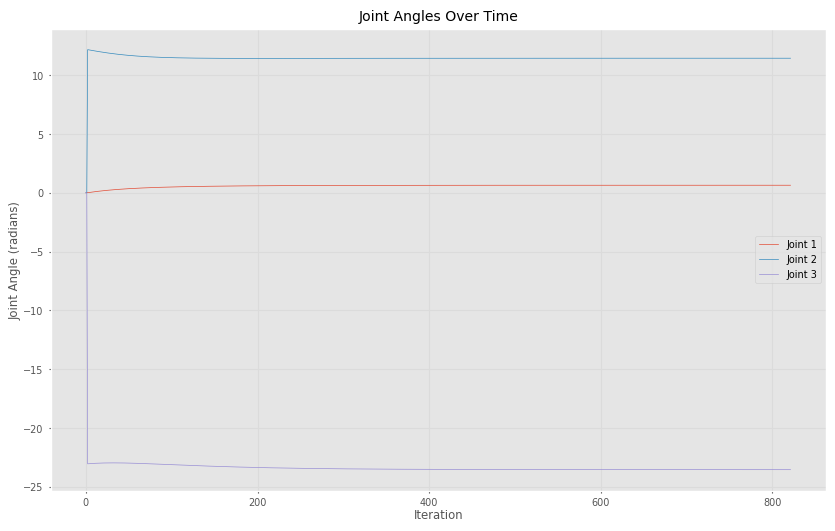

In [8]:
import roboticstoolbox as rtb
from math import pi
from spatialmath import SE3
import numpy as np
import matplotlib.pyplot as plt

# Define the robot
robot = rtb.DHRobot(
    [
        rtb.RevoluteMDH(alpha=0.0,    a=0.0,  d=0.2,  offset=0.0),
        rtb.RevoluteMDH(alpha=pi/2,   a=0.0,  d=0.02, offset=0.0),
        rtb.RevoluteMDH(alpha=0.0,    a=0.25, d=0.0,  offset=0.0),
    ],
    tool=SE3.Tx(0.28),
    name="RRR_Robot"
)

# Initial joint angles (in radians)
q = np.array([0.0, 0.0, 0.0])

# Desired end-effector position (p_setpoint)
# Let's set the desired position to (0.3, 0.2, 0.1)
p_setpoint = np.array([0.3, 0.2, 0.1])

# Control parameters
kp = 1.0   # Proportional gain
dt = 0.01  # Time step
iterations = 1000  # Maximum number of iterations

# Lists to store data for plotting and analysis
errors = []
positions = []
q_history = []  # To store joint angles at each iteration

for i in range(iterations):
    # Record the current joint angles
    q_history.append(q.copy())
    
    # Forward kinematics to get current end-effector position
    T = robot.fkine(q)
    p_now = T.t  # Extract translational component
    positions.append(p_now)
    
    # Compute position error
    error = p_setpoint - p_now
    errors.append(np.linalg.norm(error))
    
    # Stop if error is small enough
    if np.linalg.norm(error) < 1e-4:
        print(f"Converged in {i} iterations")
        break
    
    # Compute desired end-effector velocity (p_dot)
    p_dot = kp * error
    
    # Compute Jacobian
    J = robot.jacob0(q)
    J_pos = J[0:3, :]  # Position part of the Jacobian
    
    # Compute joint velocities (q_dot)
    q_dot = np.linalg.pinv(J_pos) @ p_dot
    
    # Update joint angles
    q = q + q_dot * dt

# Record the final joint angles
q_history.append(q.copy())

# Convert q_history to a NumPy array for easier manipulation
q_history = np.array(q_history)

# Print final joint angles
print("Final joint angles (in radians):", q)
print("Final end-effector position:", robot.fkine(q).t)
print("Desired end-effector position:", p_setpoint)

# Plotting the joint angles over iterations
plt.figure(figsize=(10, 6))
plt.plot(q_history[:, 0], label='Joint 1')
plt.plot(q_history[:, 1], label='Joint 2')
plt.plot(q_history[:, 2], label='Joint 3')
plt.xlabel('Iteration')
plt.ylabel('Joint Angle (radians)')
plt.title('Joint Angles Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
print("Iteration | Joint 1 (rad) | Joint 2 (rad) | Joint 3 (rad)")
print("-----------------------------------------------")
for idx in range(0, len(q_history), 50):
    print(f"{idx:9d} | {q_history[idx, 0]:13.6f} | {q_history[idx, 1]:13.6f} | {q_history[idx, 2]:13.6f}")


Iteration | Joint 1 (rad) | Joint 2 (rad) | Joint 3 (rad)
-----------------------------------------------
        0 |      0.000000 |      0.000000 |      0.000000
       50 |      0.350913 |     11.688624 |    -22.992603
      100 |      0.495356 |     11.494543 |    -23.128096
      150 |      0.562390 |     11.442145 |    -23.266580
      200 |      0.597164 |     11.432750 |    -23.368857
      250 |      0.616393 |     11.434677 |    -23.437426
      300 |      0.627424 |     11.438534 |    -23.481426
      350 |      0.633890 |     11.441839 |    -23.508996
      400 |      0.637728 |     11.444192 |    -23.526032
      450 |      0.640023 |     11.445745 |    -23.536472
      500 |      0.641402 |     11.446732 |    -23.542837
      550 |      0.642233 |     11.447346 |    -23.546706
      600 |      0.642735 |     11.447725 |    -23.549054
      650 |      0.643038 |     11.447956 |    -23.550476
      700 |      0.643221 |     11.448096 |    -23.551338
      750 |      0.64333